<a href="https://colab.research.google.com/github/Aaz96/Recommendation/blob/main/Food_item_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
nb_path = "/content/drive/My Drive/Colab Notebooks"
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)

In [ ]:
!pip install scikit-surprise --target="{nb_path}"

In [3]:
!pip install scikit-surprise

Processing /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0/scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl


# Importing the necessary libraries

In [62]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy

from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')

# Loading the datasets

In [5]:
df = pd.read_csv('/content/Food_data.csv')

In [6]:
df.head()

,UserID,Ratings,Food_item_ID
0,469,3.0,57
1,330,4.0,49
2,585,1.0,100
3,771,3.0,70
4,926,4.0,12


In [7]:
users = df['UserID'].value_counts()>=50
users = users[users].index.tolist()

In [8]:
items = df['Food_item_ID'].value_counts()>=50
items = items[items].index.tolist()

In [9]:
ratings_w_titles = df[(df['Food_item_ID'].isin(items)) & (df['UserID'].isin(users))]

In [10]:
ratings_w_titles.reset_index(drop= True, inplace= True)

In [11]:
ratings_w_titles['UserID'].value_counts().tail()

397    71
350    70
950    70
440    69
820    67
Name: UserID, dtype: int64

In [12]:
ratings_w_titles.describe()

,UserID,Ratings,Food_item_ID
count,100000.00000,100000.000000,100000.000000
mean,499.48608,2.994380,50.591190
std,288.64479,1.413184,28.831633
min,1.00000,1.000000,1.000000
25%,250.00000,2.000000,26.000000
50%,498.00000,3.000000,51.000000
75%,750.00000,4.000000,76.000000
max,1000.00000,5.000000,100.000000


In [13]:
ratings_w_titles['Food_item_ID'].nunique(), ratings_w_titles['UserID'].nunique()

(100, 1000)

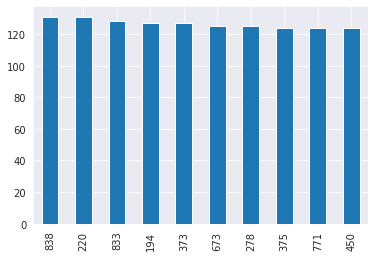

In [14]:
ratings_w_titles['UserID'].value_counts()[:10].plot(kind = 'bar')

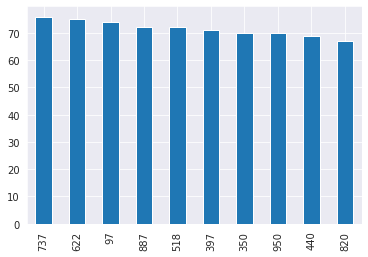

In [15]:
ratings_w_titles['UserID'].value_counts()[-10:].plot(kind = 'bar')

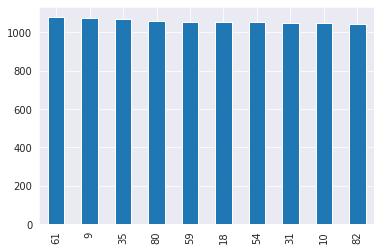

In [16]:
ratings_w_titles['Food_item_ID'].value_counts()[:10].plot(kind = 'bar')

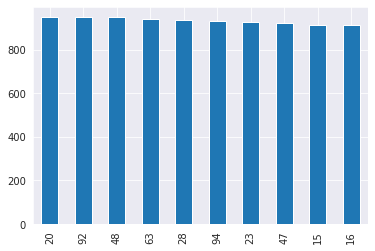

In [17]:
ratings_w_titles['Food_item_ID'].value_counts()[-10:].plot(kind = 'bar')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


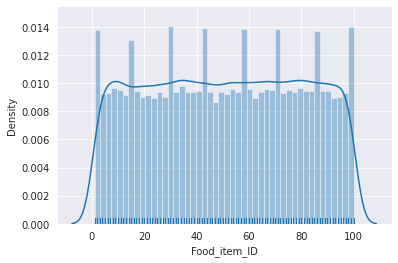

In [18]:
sns.distplot(ratings_w_titles['Food_item_ID'], rug = True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


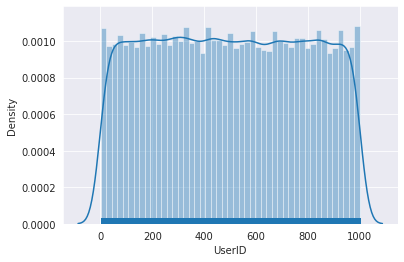

In [19]:
sns.distplot(ratings_w_titles['UserID'], rug = True)

# Popularity based Recommendation System

In [20]:
class Popularity_Recommender():
    def __init__(self):
        self.df = None
        self.user_id = None
        self.product_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, df, user_id, product_id):
        self.df_train = df
        self.user_id = user_id
        self.product_id = product_id

        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = df.groupby([self.product_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'UserID': 'Score'},inplace=True)
        print(train_data_grouped.head())
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['Score', self.product_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['UserID'] = user_id
        
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations

In [24]:
pop_recommend = Popularity_Recommender()
pop_recommend.create(df, 'UserID', 'Food_item_ID')
pop_recommend.recommend(896)

   Food_item_ID  Score
0             1    989
1             2   1023
2             3    957
3             4    991
4             5    996


,UserID,Food_item_ID,Score,Rank
60,896,61,1080,1.0
8,896,9,1073,2.0
34,896,35,1071,3.0
79,896,80,1061,4.0
58,896,59,1055,5.0
17,896,18,1053,6.0
53,896,54,1053,7.0
9,896,10,1048,8.0
30,896,31,1048,9.0
81,896,82,1042,10.0


In [25]:
pop_recommend.recommend(ratings_w_titles['UserID'].unique()[4])

,UserID,Food_item_ID,Score,Rank
60,926,61,1080,1.0
8,926,9,1073,2.0
34,926,35,1071,3.0
79,926,80,1061,4.0
58,926,59,1055,5.0
17,926,18,1053,6.0
53,926,54,1053,7.0
9,926,10,1048,8.0
30,926,31,1048,9.0
81,926,82,1042,10.0


In [26]:
pop_recommend.recommend(ratings_w_titles['UserID'].unique()[9])

,UserID,Food_item_ID,Score,Rank
60,815,61,1080,1.0
8,815,9,1073,2.0
34,815,35,1071,3.0
79,815,80,1061,4.0
58,815,59,1055,5.0
17,815,18,1053,6.0
53,815,54,1053,7.0
9,815,10,1048,8.0
30,815,31,1048,9.0
81,815,82,1042,10.0


In [27]:
pop_recommend.recommend(ratings_w_titles['UserID'].unique()[50])

,UserID,Food_item_ID,Score,Rank
60,694,61,1080,1.0
8,694,9,1073,2.0
34,694,35,1071,3.0
79,694,80,1061,4.0
58,694,59,1055,5.0
17,694,18,1053,6.0
53,694,54,1053,7.0
9,694,10,1048,8.0
30,694,31,1048,9.0
81,694,82,1042,10.0


# Collaborative Recommendation System

In [ ]:
df.head()

,UserID,Ratings,Food_item_ID
0,469,3.0,57
1,330,4.0,49
2,585,1.0,100
3,771,3.0,70
4,926,4.0,12


In [28]:
minimum = df['Ratings'].min()
maximum = df['Ratings'].max()
print('The range is between {:.1f} and {:.1f}'.format(minimum, maximum))

The range is between 1.0 and 5.0


In [29]:
reader = Reader(rating_scale=(minimum, maximum))
data = Dataset.load_from_df(df, reader)

In [30]:
from surprise.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=.95)

# Normal Predictor

In [31]:
npred = NormalPredictor()

#Training the model on the training data
npred.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = npred.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = npred.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)

# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 54.1382
MAE:  45.9967
FCP:  0.0558


0.05582303143244517

## BaseLineOnly Model

In [48]:
blo = BaselineOnly(bsl_options={'method':'sgd', 'reg':0.01, 'learning_rate':0.001})

#Training the model on the training data
blo.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = blo.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = blo.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)




Estimating biases using sgd...
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9586
MAE:  45.8046
FCP:  0.0000


0.0

# Basic KNN

In [33]:
knn = KNNBaseline(sim_options={'user_based': True})

#Training the model on the training data
knn.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9809
MAE:  45.8285
FCP:  0.1399


0.13993067289872393

# KNN with means

In [34]:
knn_m = KNNWithMeans(sim_options={'user_based': True})

#Training the model on the training data
knn_m.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_m.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_m.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 53.9921
MAE:  45.8398
FCP:  0.1586


0.15857893286462266

# KNN with ZScore

In [35]:
knn_z = KNNWithZScore(sim_options={'user_based': True})

#Training the model on the training data
knn_z.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_z.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_z.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 53.9845
MAE:  45.8323
FCP:  0.1442


0.1441761885657695

# KNN Basic Similarity Based

In [36]:
knn_bs = KNNBaseline(sim_options={'user_based': False})

#Training the model on the training data
knn_bs.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bs.predict(uid, pid, r_ui=4, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bs.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 4.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9960
MAE:  45.8447
FCP:  0.1423


0.14234549843682204

# KNN with Means Similarity Based

In [37]:
knn_bm = KNNWithMeans(sim_options={'user_based': False})

#Training the model on the training data
knn_bm.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bm.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bm.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 53.9960
MAE:  45.8447
FCP:  0.1423


0.14234549843682204

# KNN with ZScore Similarity Based

In [38]:
knn_bz = KNNWithZScore(sim_options={'user_based': False})

#Training the model on the training data
knn_bz.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bz.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bz.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 53.9959
MAE:  45.8446
FCP:  0.1416


0.14160032882209078

# Matrix Factorization Method

# Singular Value Decomposition

In [39]:
svd = SVD()

#Training the model on the training data
svd.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = svd.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = svd.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9963
MAE:  45.8449
FCP:  0.1426


0.142620614076593

# Singular Value Decomposition ++

In [40]:
# Takes a very long time to run

svdpp = SVDpp()

#Training the model on the training data
svdpp.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = svdpp.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = svdpp.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9786
MAE:  45.8265
FCP:  0.1522


0.15221868390756724

# Negative Matrix Factorization

In [41]:
nmf = NMF()

#Training the model on the training data
nmf.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = nmf.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = nmf.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': True, 'reason': 'User and item are unknown.'}


Computing the Accuracy on the test data: 
RMSE: 54.2636
MAE:  46.1343
FCP:  0.2121


0.21213454329536527

# CoClustering

In [42]:
cocl = CoClustering()

#Training the model on the training data
cocl.fit(train_df)

# we can now query for specific predicions
uid = '520'  #  user id
pid = '50'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = cocl.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = cocl.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 520        item: 50         r_ui = 3.00   est = 5.00   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 53.9754
MAE:  45.8224
FCP:  0.1564


0.15636248681704312

# Lets check the best model using cross validation

In [43]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NormalPredictor(),NMF(),KNNBaseline(),KNNWithMeans(),KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,53.942554,33.809077,397.331452
BaselineOnly,53.942563,0.202333,0.210421
KNNBaseline,53.942601,34.128607,408.659852
SVD,53.942615,4.044939,0.276323
KNNWithMeans,53.942621,34.001161,404.422225
CoClustering,53.942629,1.885838,0.237569
NMF,53.944828,4.362884,0.244924
NormalPredictor,54.118512,0.132011,0.299771


In [59]:
# Use the new parameters with the train test data
algo = BaselineOnly()
algo.fit(train_df)
test_pred = algo.test(test_df)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

Estimating biases using als...
SVD : Test Set
RMSE: 53.9586


53.95863708239371

# Collborative Top 5 Recommendations for each user

In [60]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [63]:
top_n = get_top_n(test_pred, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

389 [2.0, 1.0, 3.0, 2.0, 3.0, 1.0, 2.0, 5.0, 5.0, 5.0]
340 [1.0, 1.0, 4.0, 3.0, 2.0, 1.0, 3.0, 5.0, 2.0, 2.0]
682 [5.0, 5.0, 5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 2.0, 3.0]
695 [2.0, 5.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 4.0, 1.0]
373 [5.0, 1.0, 4.0, 4.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0]
932 [2.0, 3.0, 3.0, 1.0, 4.0, 3.0, 2.0, 3.0, 5.0, 1.0]
987 [3.0, 2.0, 3.0, 5.0, 4.0, 3.0, 2.0, 2.0, 5.0, 3.0]
89 [5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 4.0, 2.0, 2.0]
229 [3.0, 1.0, 2.0, 5.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0]
586 [1.0, 2.0, 1.0, 2.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0]
676 [5.0, 4.0, 2.0, 4.0, 1.0, 3.0, 2.0, 4.0, 5.0, 1.0]
391 [4.0, 2.0, 5.0, 3.0, 4.0, 2.0, 4.0, 4.0, 1.0, 2.0]
984 [2.0, 2.0, 3.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 3.0]
407 [2.0, 4.0, 3.0, 5.0, 2.0, 5.0, 2.0, 4.0, 3.0, 5.0]
375 [3.0, 1.0, 4.0, 2.0, 1.0, 4.0, 5.0, 5.0, 3.0, 1.0]
696 [1.0, 1.0, 5.0, 1.0, 4.0, 2.0, 2.0, 4.0, 5.0, 5.0]
198 [4.0, 5.0, 3.0, 1.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0]
837 [5.0, 5.0, 5.0, 4.0, 2.0, 2.0, 3.0, 5.0, 2.0, 5.0]
143 [4.0, 4